In [1]:
import numpy as np
import torch
import torch.utils.data as utils
from albumentations import (HorizontalFlip, VerticalFlip)
import random
import torchvision.transforms.functional as TF
import PIL.Image as Image
import matplotlib.pyplot as plt
import time
import nibabel as nib
now=time.localtime(time.time())

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,i,data_path, augmentation=True):
        self.data_path = data_path
        self.data = np.load(data_path+'MRimages_{}.npy'.format(i))
        self.target = np.load(data_path+'MASK_{}.npy'.format(i))
        self.augmentation = augmentation
        print(self.data.shape)
        print(self.target.shape)
        
    def __getitem__(self, index):
        x= self.data[index]
        y = self.target[index]
        x,y=self.transform(x,y)
        
        return x,y
    
    def transform(self, data, target):
        data, target = data_augmentation(data, target, self.augmentation)
        return data, target
    
    def __len__(self):
        return len(self.data)


In [3]:
def data_augmentation(image, labels, aug=True):
    a= random.random()
    image = Image.fromarray(image)
    mask = Image.fromarray(labels)
    if aug :
        if a > 0.5 :
            augmentated = HorizontalFlip(p=1)(image=np.array (image), mask=np.array(mask))
            image = Image.fromarray(augmentated['image'])
            mask = Image.fromarray(augmentated['mask'])
    data = TF.to_tensor(np.array(image)).float()
    masks = TF.to_tensor(np.array(mask)).float()
    return data, masks

In [4]:
##==============전체 패러미터 입력창 ====================================##

number_of_p=5  # 전체 데이터셋 개수
img_size = 256 # 3d 복셀이 img_size x img_size x img_size 로 되있다고 생각한다. 
batch_size=4 # 배치 사이즈 
in_dim = 1 # 데이터 한개의 채널 개수. MR은 흑백 이미지 이므로 채널이 한개이다. 
out_dim = num_class = 6 # 총 분할해야 하는 클래스의 개수. 일단 여기서는 6종류 이므로 6개 이다. 
num_filters = 64 # 필터개수 
num_epoch = 100 # 트레이닝 횟수 
lr = 0.001 # learning rate

loss_func_switch = 1
'''0 = MSE Loss
   1 = Cross Entropy Loss
   2 = Dice Loss  다이스 로스는 폐기... 멀티 클래스 문제에서 이건 안됨 '''

##=======================================================================##

'0 = MSE Loss\n   1 = Cross Entropy Loss\n   2 = Dice Loss'

In [5]:
train_datasets=[]
test_datasets=[]

for i in range(1,number_of_p+1):
    if i == number_of_p : 
        test_datasets.append(Dataset(i,'C:/Users/BMPL/Desktop/data set/', augmentation = False))
    else:
        train_datasets.append(Dataset(i,'C:/Users/BMPL/Desktop/data set/', augmentation = True))

traindataset = torch.utils.data.ConcatDataset(train_datasets)
trainloader = torch.utils.data.DataLoader(traindataset, batch_size =batch_size, shuffle = True, num_workers=0, pin_memory=False)

testdataset = torch.utils.data.ConcatDataset(test_datasets)
testloader = torch.utils.data.DataLoader(testdataset, batch_size =1, shuffle = False, num_workers=0, pin_memory=False)


(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)
(256, 256, 256)


In [6]:
'''
for batch_idx,(data,target) in enumerate(trainloader):
    inputs, target = data, target
    inputs=inputs.squeeze()
    target=inputs.squeeze()
    print('inputs=%s'%str(inputs.shape))
    print('target=%s'%str(target.shape))
#f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')
#print(inputs[0][0])
#f.write(inputs[0][0])

f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')
line=''
enter='\n'
space=' '
for i in list(inputs[0][0]):
    line=''
    for j in list(i):
        line+=str(int(j))
        line+=space
    line+=enter
    f.write(line)
    '''

"\nfor batch_idx,(data,target) in enumerate(trainloader):\n    inputs, target = data, target\n    inputs=inputs.squeeze()\n    target=inputs.squeeze()\n    print('inputs=%s'%str(inputs.shape))\n    print('target=%s'%str(target.shape))\n#f=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')\n#print(inputs[0][0])\n#f.write(inputs[0][0])\n\nf=open('C:/Users/BMPL/Desktop/export{}{}{}{}.txt'.format(now.tm_mon,now.tm_mday,now.tm_hour,now.tm_min),'w')\nline=''\nenter='\n'\nspace=' '\nfor i in list(inputs[0][0]):\n    line=''\n    for j in list(i):\n        line+=str(int(j))\n        line+=space\n    line+=enter\n    f.write(line)\n    "

In [7]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [8]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model     

In [9]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn) # 필터갯수를 두개씩 늘린다. 
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn) #이게 업 스케일링 하는 거다. 
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn) # 이게 옆에있는 친구 끌고와서 같이 컴볼루젼 하는것, res 넷의 핵심 
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)
        
        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1))
            #nn.Softmax(dim=1))  
            #nn.Tanh()) 필수는 아님 시그모이드 함수와 유사하지만, -1~1까지 출력 범위하는 것이 다르다. 
        
            
    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [10]:
def DC(number, m1, m2): # dice score 함수 이다.  넘버는 보고싶은 세크먼테이션의 넘버링이며,  int임  
    smooth = 1. 
    num = m1.size(0)
    num2 = m1.size(1)
    mx =  np.full((num,num2), number, dtype = np.int64)
    mx = TF.to_tensor(mx).squeeze().to(device=device, dtype=torch.int64)
    
    
    mx_m1 = mx==m1
    mx_m1 = mx_m1.float()
    mx_m2 = mx==m2
    mx_m2 = mx_m2.float()
    cross_m1_m2 = mx_m1==mx_m2 # 0과 1 둘다 겹치는 부분을 True로 출력함 
    
    zero_cross_m1_m2 = mx_m1==-1*mx_m2 #0 인데 겹치는 부분만 추출하기 위해서 만든거
    
    #print(mx_m1.float().sum(),mx_m2.float().sum(), cross_m1_m2.float().sum())
    #print(cross_m1_m2.float().sum()-zero_cross_m1_m2.float().sum())
    
    dc =  (2*(cross_m1_m2.float().sum()-zero_cross_m1_m2.float().sum())+smooth)/(mx_m1.sum()+mx_m2.sum()+smooth)
    return dc 
    
def DC_zero(number, m1, m2): # dice score 함수중 0부분에 해당하는 함수 이다.  넘버는 보고싶은 세크먼테이션의 넘버링이며,  int임  
    smooth = 1. 
    num = m1.size(0)
    num2 = m1.size(1)
    mx =  np.full((num,num2), number, dtype = np.int64)
    mx = TF.to_tensor(mx).squeeze().to(device=device, dtype=torch.int64)
    
    mx_m1 = mx==m1
    mx_m1 = mx_m1.float()
    mx_m2 = mx==m2
    mx_m2 = mx_m2.float()
    cross_m1_m2 = m1==100*m2 # m2에 100을 곱하면 나머지 클래스들은 절대 같을수가 없다. 때문에 원래 이미지에서 0끼리겹치는 부분만 나옴    
    
    #print(mx_m1.sum(),mx_m2.sum(), cross_m1_m2.float().sum())
    
    dc =  (2*cross_m1_m2.float().sum()+smooth)/(mx_m1.sum()+mx_m2.sum()+smooth)
    return dc 

In [11]:
class MSE_Loss(nn.Module):
    # y= [4,256,256] , output = [4,6,256,256]
    def __init__(self):
        super(MSE_Loss,self).__init__()
        pass
    
    def forward (self, output, y):
        soft_max = nn.Softmax(dim =1)
        output2 = soft_max(output).to (device)
        output2 = output2.permute(0,2,3,1).contiguous().to (device) # 차원을 바꿀때에는 transpose 나 permute를 사용한다. 
        
        one_hot = torch.zeros(batch_size, img_size, img_size, num_class).to (device)
        y2 = y.unsqueeze(3).to (device)
        y3 = one_hot.scatter_(3, y2, 1). to (device) 
        # 3이 들어간 이유는 scatter_에서 차원을 맞춰줘야하기 때문이다. [4,256,256,6], [4,256,256,1]의 다른 부분은 dim=3 이기 떄문. 
        loss = nn.MSELoss()(output2, y3).to (device) 
        return loss
    
class Dice_Loss(nn.Module): # 폐기된 함수입니다. ㅜㅜ 
    # y= [4,256,256] , output = [4,6,256,256]
    def __init__(self):
        super(Dice_Loss,self).__init__()
        pass
    
    def forward (self, output, y):
        smooth = 1. 
        
        soft_max = nn.Softmax(dim =1)
        output2 = soft_max(output).to (device)
        output2 = output2.permute(1,0,2,3).contiguous().to (device)
        #output2=[6,4,256,256]
        self.output2 = output2
        self.y = y
        
        sum_p_list=[]
        mul_list = []
        w_list = []
        loss=1.
        #tt=0
        for i in range (0,num_class):
            if i ==0 :
                sum_p, mul, w = self.dice(i)
                k = (2*(mul)+smooth)/(sum_p+smooth)
                loss-=w*k/num_class
    
            else:
                sum_p, mul, w = self.dice(i)
                k = (2*(mul)+smooth)/(sum_p+smooth)
                loss-=w*k/num_class
            sum_p_list.append(sum_p)
            mul_list.append(mul)
            #w_list.append(w)
               
            #tt+=a
        #print(tt)
       
        sum_p_tensor= torch.FloatTensor(sum_p_list).to(device)
        mul_tensor = torch.FloatTensor(mul_list).to(device)
       # w_tensor = torch.FloatTensor(w_list).to(device)
        
        #loss =  1. - (2*(mul_tensor).sum()+smooth)/((sum_p_tensor).sum()+smooth)
        #loss.requires_grad=True # loss 를 float 으로 출력하게 되는데 이는 TRUE 가 아니라서 문제가 된다. 
        return loss
    
    def dice(self, i): # i 는 해당 클래스의 넘버 
        output_i = self.output2[i]#output_i = [4,256,256] 각 픽셀이 클래스 i 에 해당될 확률임 
        
        num, num2, num3 = self.y.size(0), self.y.size(1), self.y.size(2)
        mx =  np.full((num,num2,num3), i, dtype = np.int64)
        mx = torch.FloatTensor(mx).to(device)
    
        mx_y = mx==self.y
        mx_y = mx_y.float()
        
        sum_p = mx_y.sum() + output_i.sum()
        mul = (mx_y*output_i).sum()
        w= batch_size*img_size*img_size/(num_class*mx_y.sum()+1.)
        #w = 1/((mx_y.sum())**(2)+1.)
        a = output_i.sum()
        
        return sum_p, mul, w# , a
    
    def dice_zero(self, i): # i=0 일때 따로 돌린다. 백르라운드 자체가 너무 많기 때문에.. 
        output_i = self.output2[i]#output_i = [4,256,256] 각 픽셀이 클래스 i 에 해당될 확률임 
        
        num, num2, num3 = self.y.size(0), self.y.size(1), self.y.size(2)
        mx =  np.full((num,num2,num3), i, dtype = np.int64)
        mx = torch.FloatTensor(mx).to(device)
    
        mx_y = mx==self.y
        mx_y = mx_y.float()
        
        sum_p = 2.-mx_y.sum() - output_i.sum()
        mul = ((1.-mx_y)*(1.-output_i)).sum()
        w= mx_y.sum()
        #w = 1/((mx_y.sum())**(2)+1.)
        a = output_i.sum()
        return sum_p, mul, w

In [12]:
def check_output(i, x, y, output, export):
    zeros=np.zeros((img_size,img_size,1))
    x_sample=x[i].cpu()/256
    y_sample=y[i].cpu()*50/256
    output_sample=output[i].cpu()*50/256 
        
    x_sample2=np.reshape(x_sample, (img_size, img_size, 1))
    y_sample2=np.reshape(y_sample, (img_size, img_size, 1))
    ouput_sample2 = np.reshape(output_sample,(img_size,img_size,1))

    x_image=np.concatenate((x_sample2, x_sample2, x_sample2), axis = 2)
    y_image=np.concatenate(( zeros, y_sample2,  zeros), axis = 2)
    output_image=np.concatenate(( zeros, ouput_sample2, zeros), axis = 2)
        
    origin_image = x_image+y_image
    AI_image = x_image+output_image

    plt.subplot(131)
    plt.imshow(x_image)
    plt.subplot(132)
    plt.imshow(y_image)
    plt.subplot(133)
    plt.imshow(output_image)
        
    if export == True : 
        plt.savefig('C:/Users/BMPL/Desktop/test_{}.png'.format(i) , dpi=300)
    plt.show()

총 배치의 수 : 256

------Initiating U-Net------

tensor(0.0084, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0942, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0286, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0288, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0843, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0399, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0103, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1768, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1778, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.1923, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0523, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0125, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2064, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1258, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1395, device='cuda:0', grad_fn=<DivBackward0>)
ten

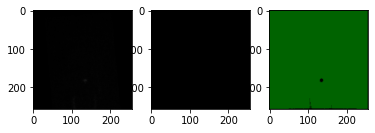

tensor(0.0131, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1983, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.2121e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(20.4540, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1970, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1758, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.2296e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(33.3550, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2316, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1268, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.9724e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3653, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2299, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', gr

tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2321, device='cuda:0', grad_fn=<DivBackward0>)
tensor(16.7968, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.7860e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1644, device='cuda:0', grad_fn=<DivBackward0>)
tensor(17.4716, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0082, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0973, device='cuda:0', grad_fn=<DivBackward0>)
tensor(19.4647, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<

tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2465, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.1802e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.8542, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0320, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.3977e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2287, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5718e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.3567, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0426, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0127, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2233, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5313e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7341, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0453, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', 

tensor(43677.7578, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0333, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0121, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1959, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7742e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12.0525, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0296, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.6236e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1938, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.0465e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43677.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0653, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1274, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2840e-05, device='

tensor(0.0117, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1006, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.7395e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43685.6484, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1396, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0122, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1371, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.7073e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43685.4688, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1280, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0137, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1775, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.2970e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6920, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:

tensor(0.1477, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1768, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7000e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.4217, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0539, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.7468e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1414, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.7666e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5040, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1269, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1801, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.3292e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.8438, device='cuda:

tensor(0.0125, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0693, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.7931e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43685.9062, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0145, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2093, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.1911e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2362, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0590, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.8441e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1815, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5998e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(21.0964, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0283, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.6867e-05, device='

tensor(43686.6797, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1505, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0485, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43682.8516, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2161, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1844, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.3243e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8339, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0794, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2042, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.0970e-05, device='cuda:0', 

tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1789, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.0463e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23.5655, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0725, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0480, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.0681e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43687.0156, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2031, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0151, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2228, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.4661e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5267, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0545, device='cuda:0',

tensor(0.0127, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1732, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.0852e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.9844, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0857, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0122, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1231, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.4534e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43687.9375, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1195, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0129, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1242, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.6382e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.6337, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1281, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:

tensor(0.0141, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2057, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.0898e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.6406, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0536, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.3329e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2063, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.8205e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.7891, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0481, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.9867e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1019, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.9692e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.8750, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1403, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, d

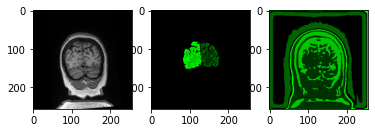

tensor(0.0151, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2220, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.4904e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(54.3415, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0445, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.0798e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0133, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2289, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.3437e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.7930, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0513, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0132, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1807, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.0122e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43687.7266, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0920, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='

tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1867, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.1165e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(46.0386, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0256, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3371, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6096, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43624.3594, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5596, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.2765, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4648, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5965, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43677.8945, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.0656, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5838, device='cuda:0', gra

tensor(0.0355, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.8957e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0840, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.4301e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.8906, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1947, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0153, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1999, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.4413e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.2109, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0905, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.7330e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0134, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1838, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.7455e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.5312, d

tensor(0.0162, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2115, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.2638e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(39.5032, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0601, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.3973e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1816, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5211e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.8599, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0321, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0382, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.5097e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43686.5742, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2729, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0005, device='cuda

tensor(0.0145, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1801, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2040e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.4297, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0805, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3769, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6145, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43684.6523, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8066, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.3123, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1777, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.1707e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8339, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0491, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.7838e-05, device='cuda:

tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1620, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.7781e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(79.4374, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0633, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2068, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.3720e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.7812, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0320, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1157, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.9621e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.8711, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1207, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda

tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2212, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2304e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(234.8954, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0248, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0145, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1836, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.8462e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.6172, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0604, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.1545e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0146, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1930, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.6896e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.1016, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0421, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device=

tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2094, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.0256e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.2812, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0541, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0836, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.3571e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.1367, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1775, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2227, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.6502e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.9844, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0641, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='c

tensor(0.0152, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2023, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.7782e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.2656, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0579, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0983, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.7107e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6920, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1465, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2213, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.1732e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.8599, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0378, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', 

tensor(0.1514, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8526e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5092, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0125, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1495, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.1014e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8339, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1099, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1956, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.3287e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.0312, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0241, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0137, device='cuda:0', 

tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1930, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.3080e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.2617, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0361, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0152, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2197, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.5331e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.5430, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0577, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0149, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1732, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.9758e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(79.4375, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0269, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.6993e-05, device='

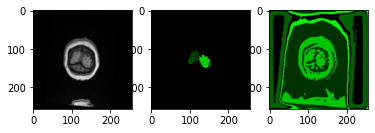

tensor(0.0153, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2234, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4685e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.8906, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0254, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0141, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2192, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.3981e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.1562, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0226, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0156, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1979, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.2466e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5451, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0428, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.3020e-05, device='c

tensor(0.0141, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1601, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.6090e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.8461, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0176, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.3177e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1925, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.6199e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3711, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0258, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.7035e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0165, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2177, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.6234e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5546, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0265, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.7031e-05, devic

tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0141, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1571, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7289e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.4574, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0195, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.4341e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1079, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.0625, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1777, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1527, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.2415e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.1562, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0828, device='cuda:

tensor(0.0119, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1050, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.5723e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.9922, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1704, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0128, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1367, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.9368e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.5000, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0924, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0957, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.0683e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.7344, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1812, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0004, device='c

tensor(0.0151, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1782, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.6905e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.1094, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0595, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1935, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5817e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.4217, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0218, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.2365e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1857, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.1693e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0198, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.0159e-05, devic

tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2103, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.5243e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.9375, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0625, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0152, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1763, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.3386e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9074, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0234, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.5095e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0552, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.9931e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2163, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2621, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:

tensor(0.0143, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1939, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.5016e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(127.0075, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0501, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2191, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.9478e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3483, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0429, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0129, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1372, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.8695e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.8359, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1334, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0'

tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1561, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.5547e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.0898, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1017, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0166, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2038, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5761e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(23.5656, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0487, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.8268e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0141, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1986, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.2967e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3828, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='

tensor(0.0149, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1987, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8129e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(14.2827, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0354, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0157, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1818, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.7556e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4609, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0328, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0111, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1037, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.2652e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.6719, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1352, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda

tensor(0.0135, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1253, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0415e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.1094, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1309, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1413, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4160e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5040, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0864, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0153, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1966, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.6727e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.7368, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0312, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', 

tensor(9.5864e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0135, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1186, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0749e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.0391, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1239, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1725, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.0737e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.3281, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0774, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2091, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.3931e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(12.0526, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0319, device='

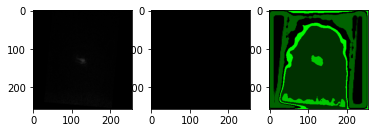

tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1909, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.7130e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6532, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0465, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2100, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8208e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.0893, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0504, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0138, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1823, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.9979e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.2891, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0589, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', 

tensor(0.0122, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0837, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.7502e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.9531, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1753, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0153, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1866, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.1081e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4062, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0300, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2011, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8843e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4844, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0242, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='c

tensor(0.0153, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1820, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8643e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4297, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0572, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0157, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1841, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.9575e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.2031, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0490, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1409, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5808e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(349.5251, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.4574e-05, device=

tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0537, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.1468e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.6641, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3125, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0133, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1256, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.4188e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.1953, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1175, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0151, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1679, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.3679e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.5391, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0199, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='c

tensor(0.1796, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.0222e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.0893, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0370, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1531, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.0430, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0706, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0176, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1997, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.6431e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(79.4375, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0433, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.4669e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0168, device='cuda:0',

tensor(0.0147, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1686, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.4772e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.2930, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0694, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0151, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2153, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.4572e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3906, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0233, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1600, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.1736e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2362, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:

tensor(0.1991, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.3987e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4844, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0278, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2174, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8606e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3594, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0504, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2047, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.5106e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.1172, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0629, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0153, device='c

tensor(0.1875, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.0678e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3555, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0541, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0594, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.6484, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3983, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0155, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1585, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.9270e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(127.0077, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0264, device='cuda:0', grad_fn=<DivBackward0>)
tensor(6.6859e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0117, device='cud

tensor(0.0172, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1819, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5400e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4922, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0442, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4819e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1492, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.1641, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0818, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0173, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2106, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.7006e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.2891, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0391, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='c

tensor(0.0164, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2084, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.6307e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3359, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0430, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0152, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1854, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.4224e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.3571, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0231, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0339, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.5703, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3154, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0040, device='cuda:0', 

tensor(0.1821, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.7140e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.5078, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0393, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0156, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1574, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.1287e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3281, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1032, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0175, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2213, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.6174e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43689.9609, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0686, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0159, device='c

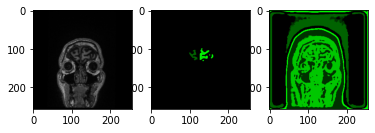

tensor(0.0140, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1143, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.6621e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3242, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1489, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1878, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.3486e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.5469, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0300, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0165, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1995, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.3117e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3359, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0720, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='c

tensor(0.1938, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.8846e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(127.0077, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0387, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.9706e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1718, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.2664e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.2344, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0903, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1528, device='cuda:0', grad_fn=<DivBackward0>)
tensor(5.4560e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4453, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0704, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0159, device=

tensor(0.0163, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1702, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.1673e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5745, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0507, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0156, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1696, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.8447e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.8920, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0262, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0163, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1701, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.5211e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(46.0386, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0469, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.8667e-05, device='cuda:0',

tensor(0.0424, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0167, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1949, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.6233e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5267, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0607, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0152, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0772, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.9405e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43688.9297, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1842, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0165, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1776, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.1921e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(46.0386, device='cuda:0',

tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0159, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1720, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.3171e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.3438, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0849, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0154, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1533, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.5980e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4805, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0656, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0157, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1630, device='cuda:0', grad_fn=<DivBackward0>)
tensor(2.6020e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.3822, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0401, device='cuda:

tensor(0.0161, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1803, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.2820e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(39.5033, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0529, device='cuda:0', grad_fn=<DivBackward0>)
tensor(9.3827e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.0393e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(99.0718, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1032, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.2540e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(43690.4023, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1354, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0003, device='cud

KeyboardInterrupt: 

In [13]:
total_batch = len(trainloader)
print('총 배치의 수 : {}'.format(total_batch))

# 앞서 정의한대로 vGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = UnetGenerator(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to(device)

##===========================IMPORTANT!!!!!========================================================##
# 손실함수 및 최적화함수를 설정합니다.
if loss_func_switch == 0 :
    MSE_Loss2=MSE_Loss().to(device)
    loss_func = MSE_Loss2

elif loss_func_switch ==1 :
    loss_func =  nn.CrossEntropyLoss()

elif loss_func_switch ==2 :
    Dice_Loss2 = Dice_Loss().to(device)
    loss_func = Dice_Loss2 

    
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99)
optimizer =  torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = lr)# lr = learning rate

##=================================================================================================##



for i in range(num_epoch):
    avg_cost = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        x, y = data.to(device), target.squeeze().to(device=device, dtype=torch.int64)
        # x= [4,1,256,256], y= [4,256,256] , output = [4,6,256,256]
      
        optimizer.zero_grad()
        output = model.forward(x)
        
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        avg_cost += loss / total_batch
        
        if batch_idx==10:
            output_label = torch.argmax(output, dim=1)
            check_output(0, x.squeeze(), y, output_label, export = False)
        
    print('[Epoch: {:>4}] cost = {:>.9}'.format(i + 1, avg_cost))
    



In [ ]:
#del trainloader
del x 
del y
torch.cuda.empty_cache()
ouput_list=[]
x_list=[]
y_list=[]
with torch.no_grad(): # 그레디언트 계산 안하려고 쓰는 거임 
    for batch_idx, (data, target) in enumerate(testloader):
        x, y = data.to(device), target.squeeze(0).to(device=device, dtype=torch.int64)
        # x= [1,1,256,256], y= [1,256,256] , output = [1,6,256,256]
        output = model.forward(x)
        
        output_label = torch.argmax(output, dim=1)
        # ouput_label= [1,256,256]
        ouput_list.append(output_label)
        x_list.append(x.squeeze(0))
        y_list.append(y)
    
    output_final=torch.cat(ouput_list,dim=0)
    x_final = torch.cat(x_list,dim = 0)
    y_final = torch.cat(y_list,dim = 0)
    
    num = output_final.size(0)
    
    m1 = y_final.view(num, -1)  # Flatten
    m2 = output_final.view(num, -1)  # Flatten
    
    dc_list = []
    #print('sum = ', m1.sum(), m2.sum())
    #correct_prediction = m1 == m2
    #accuracy = correct_prediction.mean()
    #print('Accuracy: ', accuracy.item())
        
    for i in range (num_class):
        if i == 0:
            dc =  DC_zero(i, m1, m2)
            dc_list.append(dc.item())
            print('dice coefficient_{}: '.format(i), dc.item())
        else :
            dc =  DC(i, m1, m2)
            dc_list.append(dc.item())
            print('dice coefficient_{}: '.format(i), dc.item())
    print('dice coefficient_mean: ', sum(dc_list)/len(dc_list))
    
#ni_img = nib.Nifti1Image(output_final.cpu(), affine=output_final.cpu())
#nib.save(ni_img, 'C:/Users/BMPL/Desktop/data set/AI_seg.nii.gz')
        


In [ ]:
##==============보고싶은 레이어 넘버 입력창 ==============================##
n_layer=100
##=======================================================================##

check_output(n_layer, x_final, y_final, output_final, export = True)

In [ ]:
q =np.array([[0,1,2],[0,1,2],[0,1,10]])
q2=TF.to_tensor(q).squeeze()
print(q2)
tensor = torch.zeros(3,3)
tensor2=tensor==q2

print(tensor2)

In [ ]:
m1 = torch.FloatTensor([[1, 2, 3], [3, 3, 4]])
m2 = torch.FloatTensor([[1, 2, 4], [2, 6,3]])
print(m1 * m2)

In [ ]:
print(10.-m1)